In [ ]:
!pip install medmnist

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


# 2D dataset with size 224x224

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

In [5]:

#Load training and test data

data_flag = 'dermamnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
val_dataset =  DataClass(split='val', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224, mmap_mode='r')



# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False) #False, will not train the model
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz


In [ ]:
#potential denoise Bregman as mathematically expressed in report
"""
count=0
for image in train_dataset:
    if image[1]==0:
        count=count+1
        plt.subplot(4,5,count*2-1)
        plt.imshow(image[0].permute(1, 2, 0))
        image_denoise=skimage.restoration.denoise_tv_bregman(image[0].permute(1, 2, 0),0.01)
        plt.subplot(4,5,count*2)
        plt.imshow(image_denoise)
        if count>=10:
            break
"""

In [ ]:
# If needed, data augmentation. NOTE; need to restructure code if you want to use it. Did not increase accuracy
"""
for image in train_dataset:
    if image[1]!=[5]:
        image_swap= image[0].permute(1, 2, 0)  # turn the image representation into shape(m,n,3)
        hflipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        image_augmented_1=hflipper(image_swap)
        augmented_data.append([image_augmented_1,image[1]])
        vflipper=torchvision.transforms.RandomVerticalFlip(p=0.5)
        image_augmented_2=vflipper(image_swap)
        #resize_cropper = torchvision.transforms.RandomResizedCrop(size=(224,224),scale=(0.8,1),ratio=(0.8,1.5))
        #image_augmented_3=resize_cropper(image_swap)
        augmented_data.append([image_augmented_2,image[1]])
        #augmented_data.append([image_augmented_3,image[1]])
        jitter=torchvision.transforms.ColorJitter(brightness=(0.8,1.2))
        jitter_image=jitter(image[0])
        augmented_data.append([jitter_image,image[1]])
"""

In [6]:
#HSV feature extraction
from skimage.color import rgb2hsv

num_classes = 7

def hsv_feature(dataset):

    hsv_feature_matrix = []

    class_hue_hists = np.zeros((num_classes, 50))
    class_sat_hists = np.zeros((num_classes, 50))
    class_val_hists = np.zeros((num_classes, 50))
    num_points_in_class = np.zeros((num_classes,1))


    for i in tqdm(range(len(dataset))):
        x, y = dataset[i]
        x_numpy = x.numpy()  # Convert tensor to numpy array
        class_idx = y.item()
        """
        # Rescale the pixel values from [-1, 1] to [0, 1], since the DataClass is initialized with values in [-1,1]
        x_rescaled = (x_numpy + 1) / 2.0
        """
        x_numpy = np.transpose(x_numpy, (1, 2, 0))  # Convert to [H, W, C] for skimage
        
        # Convert the RGB image to HSV using skimage
        hsv_img = rgb2hsv(x_numpy) #returns normalized values in [0, 1] for H,S,V

        #make feature vector:
        # Make all values between 0-255 to make bins in histogram
        hue_values = hsv_img[:, :, 0] * 255 
        sat_values = hsv_img[:, :, 1] * 255
        val_values = hsv_img[:, :, 2] * 255

        # Now calculate histograms for each channel
        hue_hist, _ = np.histogram(hue_values, bins=np.linspace(0, 255, 51))
        sat_hist, _ = np.histogram(sat_values, bins=np.linspace(0, 255, 51))
        val_hist, _ = np.histogram(val_values, bins=np.linspace(0, 255, 51))

        # Concatenate histograms to form a feature vector
        hsv_feature_vector = np.concatenate((hue_hist, sat_hist, val_hist)) 
        hsv_feature_matrix.append(hsv_feature_vector)

        # For the plotting, get a density array and keep track of histogram for each class

        class_hue_hists[class_idx] += hue_hist/(224*224)
        class_sat_hists[class_idx] += sat_hist/(224*224)
        class_val_hists[class_idx] += val_hist/(224*224)
        num_points_in_class[class_idx] += 1
    hsv_feature_matrix = np.array(hsv_feature_matrix) #feature vector, shape (7007, 765)

    class_hue_hists /= num_points_in_class
    class_sat_hists /= num_points_in_class
    class_val_hists /= num_points_in_class
    
    return hsv_feature_matrix, class_hue_hists, class_sat_hists, class_val_hists


In [7]:
#Do HSV feature extraction on train data

hsv_feature_matrix, class_hue_hists, class_sat_hists, class_val_hists = hsv_feature(train_dataset)

100%|██████████| 7007/7007 [02:31<00:00, 46.15it/s]


In [8]:
print(hsv_feature_matrix.shape)
print(class_hue_hists.shape)

(7007, 150)
(7, 50)


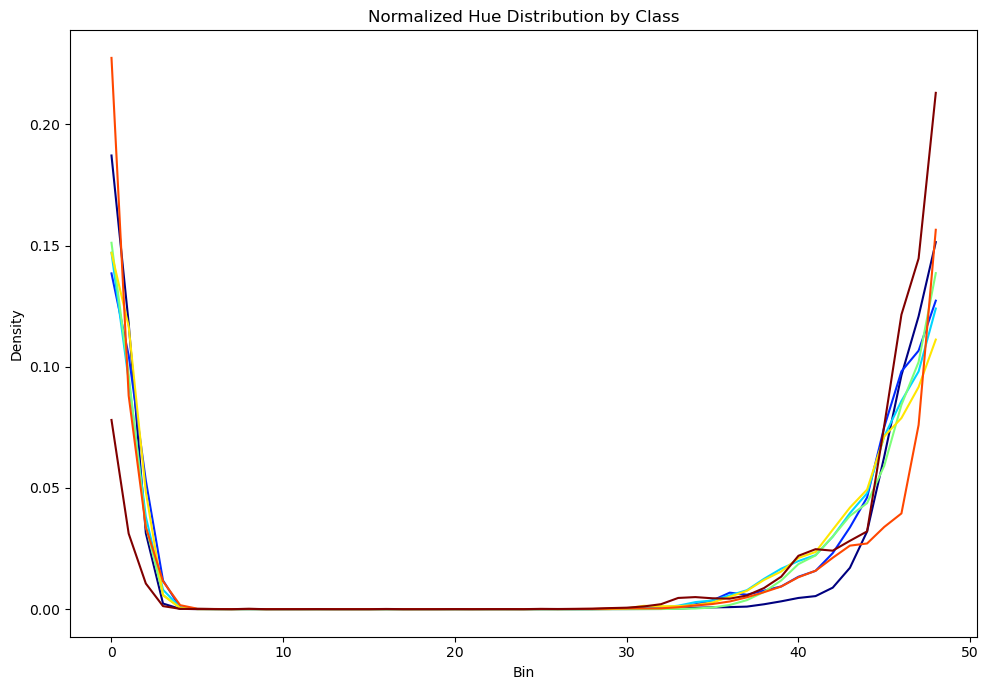

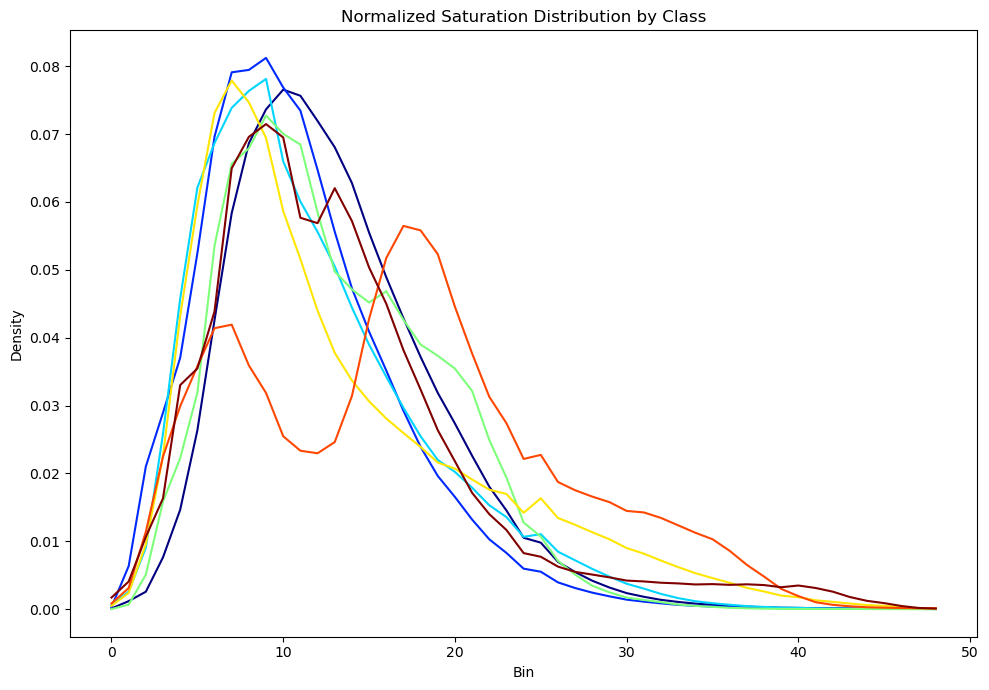

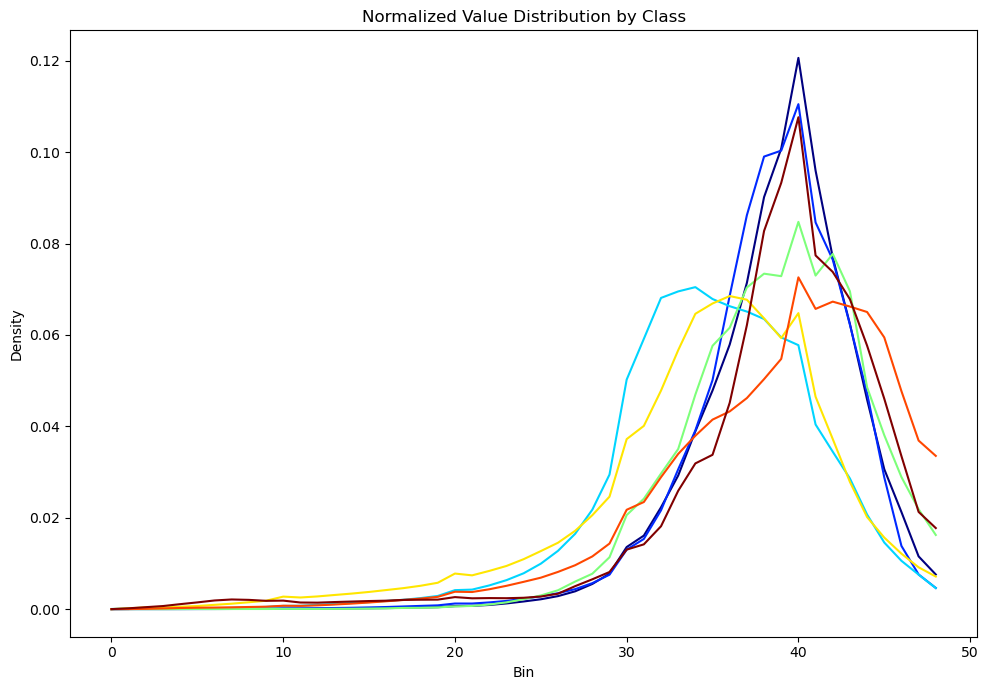

In [10]:
dermamnist_labels = INFO['dermamnist']['label']

def plot_class_histograms(histograms, title, xlabel='Bin', ylabel='Density'):
    plt.figure(figsize=(10, 7))
    colors = plt.cm.jet(np.linspace(0, 1, len(histograms)))
    for class_idx, hist in enumerate(histograms):
        # Use the class index to get the corresponding class name from the dictionary
        class_name = dermamnist_labels[str(class_idx)]
        plt.plot(hist[:-1], color=colors[class_idx])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
    
plot_class_histograms(class_hue_hists, 'Normalized Hue Distribution by Class')
plot_class_histograms(class_sat_hists, 'Normalized Saturation Distribution by Class')
plot_class_histograms(class_val_hists, 'Normalized Value Distribution by Class')

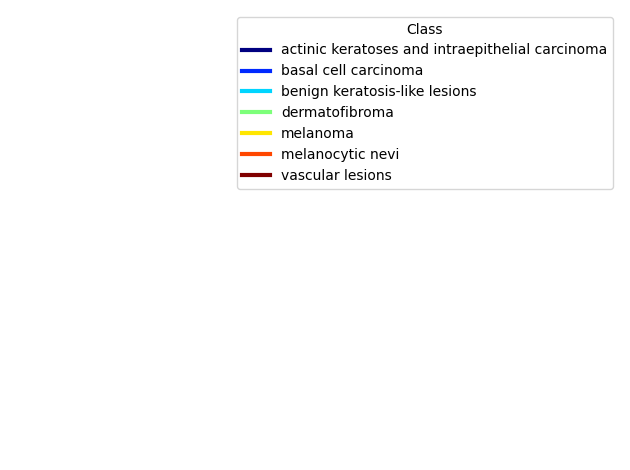

In [11]:
def plot_labels_legend():
    # Create a figure specifically for the legend
    fig, ax = plt.subplots()
    colors = plt.cm.jet(np.linspace(0, 1, len(dermamnist_labels)))
    # Create dummy lines for each label
    lines = [plt.Line2D([0], [0], color=colors[class_idx], linewidth=3) for class_idx in range(len(dermamnist_labels))]
    # Add the legend using these dummy lines
    ax.legend(lines, [dermamnist_labels[str(class_idx)] for class_idx in range(len(dermamnist_labels))], title='Class')
    # Hide the axes
    ax.axis('off')
    # Adjust the layout to minimize empty space
    fig.tight_layout()
    plt.show()
    
plot_labels_legend()

In [13]:
train_dataset.montage(length=3)
print(train_dataset)

Dataset DermaMNIST of size 224 (dermamnist_224)
    Number of datapoints: 7007
    Root location: C:\Users\matia\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


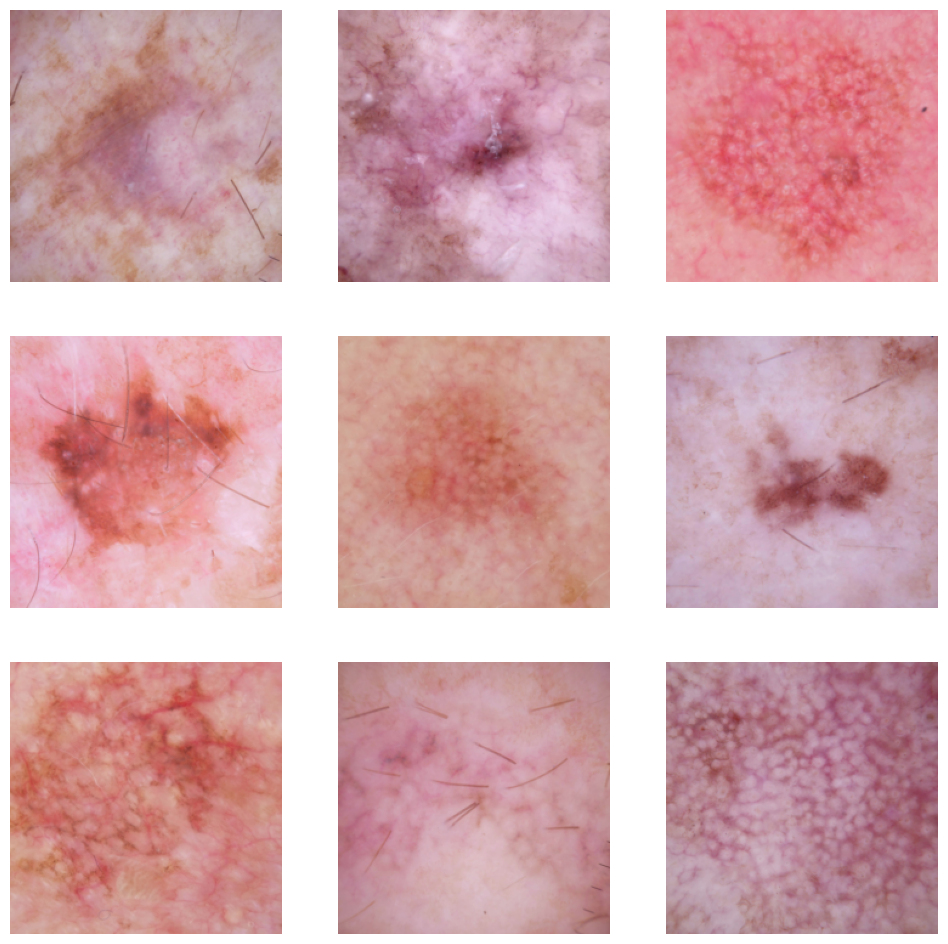

In [14]:
# Plot images from same class to analyze similarities

import matplotlib.pyplot as plt

def show_images_of_class(dataset, class_label, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    count = 0
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == class_label and count < num_images:
            ax = axes[count // 3, count % 3]
            ax.imshow(image.permute(1, 2, 0))  # Adjust for RGB images
            ax.axis('off')
            count += 1
        if count == num_images:
            break
    plt.show()
show_images_of_class(train_dataset, class_label=0)





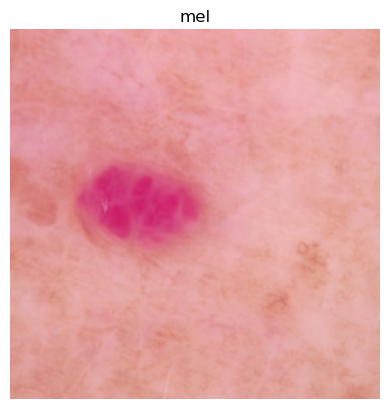

In [15]:
def plot_image_from_class(dataset, class_label):
    # Iterate over the dataset
    for image_tensor, label in dataset:
        # Check if the current label matches the class_label we're searching for
        if label.item() == class_label:
            # Convert tensor image to numpy and change dimensions to [H, W, C]
            image_numpy = image_tensor.numpy().transpose(1, 2, 0)
            # Plot the image
            plt.imshow(image_numpy)
            plt.title("mel")
            plt.axis('off')  # Hide the axis
            plt.show()
            # Break after the first match to only show one image
            break

# Example usage:
# Call this function with the train_dataset and the class label you are interested in.
# For example, to plot an image from class 6, you would call:
plot_image_from_class(train_dataset, 6)

In [82]:
# Complex feature extraction. Using ResNet18. Need a new transform to make the data compatible with resnet input

from torchvision import models, transforms
from torchvision.models import resnet18

# Load the pre-trained ResNet model
resnet18 = models.resnet18(pretrained=True)

# Remove the final fully connected layer to use the network as a feature extractor
modules = list(resnet18.children())[:-1]  # Removing the last layer
resnet18 = torch.nn.Sequential(*modules)

# Move model to CPU (remove .cuda() calls if your setup doesn't support CUDA)
resnet18 = resnet18.cpu()

# Set the model to evaluation mode
resnet18.eval()

def resnet18_feature(loader):
    # Placeholder for extracted features and labels
    features = []
    labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, targets in tqdm(loader):
            # Extract features
            output_features = resnet18(inputs)

            # Flatten the output features to a 2D array where each row is a feature vector
            output_features = output_features.view(output_features.size(0), -1)

            # Collect the features and labels
            features.append(output_features.numpy())  # Convert features to NumPy array
            labels.append(targets.numpy())

    # Convert the list of arrays to a single 2D array for features and 1D array for labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f'Extracted features shape: {features.shape}')
    print(f'Labels shape: {labels.shape}')
    
    return features, labels

C:\Users\matia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\matia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
## Do resnet feature extraction with train data

resnet_feature_matrix, labels = resnet18_feature(train_loader)

100%|██████████| 55/55 [03:32<00:00,  3.86s/it]

Extracted features shape: (7007, 512)
Labels shape: (7007, 1)


In [22]:
resnet18 = models.resnet18(pretrained=True)
class ResNet18FirstLayer(torch.nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.first_layer = pretrained_model.conv1

    def forward(self, x):
        x = self.first_layer(x)  # Outputs from the first convolutional layer
        return x

# Initialize the feature extractor model
first_layer_model = ResNet18FirstLayer(resnet18)
first_layer_model.eval()  # Set the model to evaluation mode

# Move model to CPU (remove .cpu() if your setup supports CUDA)
first_layer_model = first_layer_model.cpu()


# Get the first image
def get_first_image(loader):
    for images, _ in loader:
        return images[0].unsqueeze(0)  # Add batch dimension to fit model input requirements

image_tensor = get_first_image(train_loader)

# Get activation map from the first layer
with torch.no_grad():
    activation_map = first_layer_model(image_tensor)

# Convert activation map to numpy for visualization
activation_map = activation_map.squeeze(0).numpy()  # Remove batch dimension

# Function to visualize an activation map
def visualize_activation_map(activation_map, feature_idx):
    # Plot the selected feature map
    plt.imshow(activation_map[feature_idx], cmap='gray')
    plt.axis('off')
    plt.show()


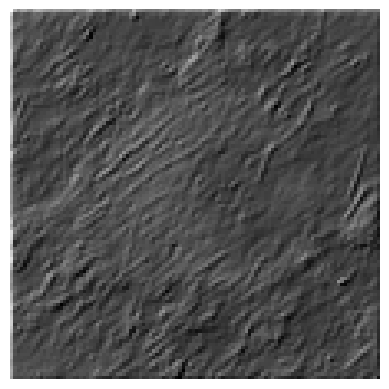

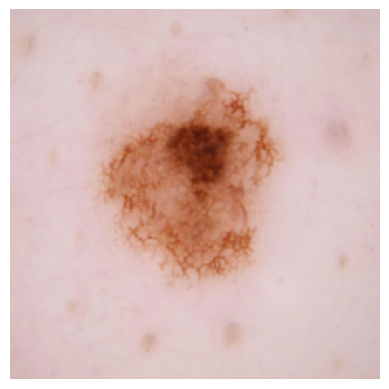

In [24]:

visualize_activation_map(activation_map, feature_idx=23)  # Feature index can be any from 0 to 511
x,y = train_dataset[4]


# Since x is a PyTorch tensor with shape [3, 224, 224] (channels first)
# Convert it for matplotlib which expects [height, width, channels]
x = x.permute(1, 2, 0)  # Adjust for RGB images

plt.imshow(x)
plt.axis('off')  # Hide axes
plt.show()


In [25]:
#LBP

from skimage import color
from skimage.feature import local_binary_pattern
#from scipy.stats import itemfreq


def lbp_features(dataset, P=8, R=1, method='uniform'):
    lbp_feature_matrix = []  # Placeholder for the LBP feature matrix

    for i in tqdm(range(len(dataset))):
        # Access the image and label
        image, label = dataset[i]
        # Ensure the image is grayscale as LBP typically works on single-channel images
        if image.shape[0] == 3:  # Assuming the image is in CxHxW format
            image = color.rgb2gray(image.permute(1, 2, 0))  # Convert to grayscale and HxWxC format
        # Calculate the LBP image
        lbp_image = local_binary_pattern(image, P=P, R=R, method=method)
        # Calculate the histogram of the LBP
        lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, P * R + 3), range=(0, P * R + 2))
        # Normalize the histogram
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)

        # Append the histogram to our feature matrix
        lbp_feature_matrix.append(lbp_hist)

    return np.array(lbp_feature_matrix)

In [26]:
#Extract feature
lbp_feature_matrix = lbp_features(train_dataset)

  0%|          | 0/7007 [00:00<?, ?it/s]C:\Users\matia\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 7007/7007 [03:04<00:00, 37.94it/s]


[0]


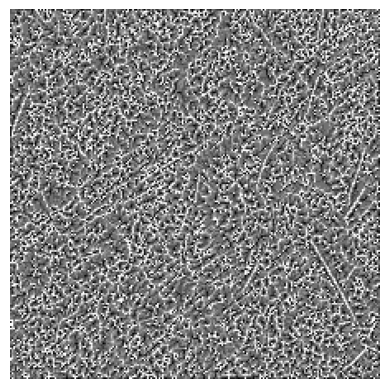

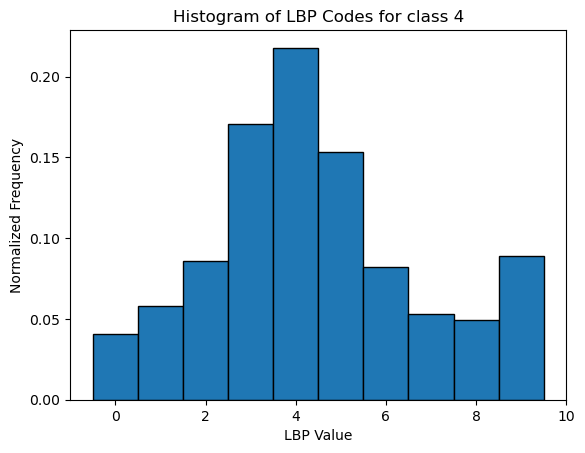

In [27]:
x, y = train_dataset[0]  # Example to get the first image
x = x.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for skimage
print(y)
# Convert to grayscale
gray_image = color.rgb2gray(x.numpy())

# Parameters for LBP
P = 8  # Number of circularly symmetric neighbour set points
R = 1  # Radius of circle
method = 'uniform'

# Calculate the LBP representation of the image
lbp_image = local_binary_pattern(gray_image, P, R, method)

# Plotting the LBP image
plt.imshow(lbp_image, cmap='gray')
#plt.colorbar()
#plt.title('Local Binary Pattern Image')
plt.axis('off')
plt.show()

lbp_hist, bins = np.histogram(lbp_image.ravel(), bins=np.arange(0, P * R + 3), range=(0, P * R + 2))

# Normalize the histogram
lbp_hist = lbp_hist.astype('float')
lbp_hist /= (lbp_hist.sum() + 1e-6)

# Plotting the histogram
plt.bar(bins[:-1], lbp_hist, width=bins[1] - bins[0], edgecolor='black')
plt.title('Histogram of LBP Codes for class 4')
plt.xlabel('LBP Value')
plt.ylabel('Normalized Frequency')
plt.show()

In [28]:
#HOG feature extraction
from skimage.feature import hog
from skimage import exposure
from torch.utils.data import Subset

def hog_features(dataset, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=6):
    """
    Extract HOG features from a dataset where each item is a tuple (tensor, label).
    
    Parameters:
    - dataset: Iterable dataset where each item is a tuple (tensor, label).
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - orientations: Number of orientation bins.
    
    Returns:
    - feature_matrix: A matrix of size (number of images, number of features).
    """
    feature_list = []
    img_l = []
    # Extract HOG features for each image in the dataset
    for image, label in tqdm(dataset):
        # The dataset provides the image as a PyTorch tensor. Convert it to a numpy array.
        image_np = image.permute(1, 2, 0).numpy()  # Convert from (3, 224, 224) to (224, 224, 3)
        image_np = color.rgb2gray(image_np)  # Convert to grayscale as HOG is typically applied on grayscale images

        # Compute HOG features for the grayscale image
        hog_features, img = hog(image_np, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys',
                           visualize=True,
                           feature_vector=True)

        # Append the features to the feature list
        feature_list.append(hog_features)
        img_l.append(img)
    # Convert the list of features into a numpy array
    feature_matrix = np.array(feature_list)
    img = np.array(img_l)
    return feature_matrix, img



In [105]:
def fft_feature_aug(data):
    fft_feature_vectors = []

    for items in data:
        image = items[0]
        label = items[1]

        if isinstance(label, list):
            label = label[0]

        # Calculate FFT
        fft_result = np.fft.fft2(image)

        # centered the result of FFT
        fft_centered = np.fft.fftshift(fft_result)

        # compute the spectrum of FFT
        magnitude_spectrum = np.abs(fft_centered)

        # energy
        energy = np.sum(magnitude_spectrum**2)

        # spectral entropy
        normalized_spectrum = magnitude_spectrum / np.sum(magnitude_spectrum)
        spectral_entropy = -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-8))

        # use magnitude as feature vector
        magnitude_spectrum_flattened = magnitude_spectrum.flatten()

        # create feature vector
        fft_feature_vector = np.hstack((magnitude_spectrum_flattened.mean(), energy.mean(), spectral_entropy.mean()))
        fft_feature_vectors.append(fft_feature_vector)


        # append the features
    fft_feature_matrix = np.array(fft_feature_vectors)

    #pca=PCA(n_components=100)
    #fft_feature_matrix=pca.fit_transform(fft_feature_matrix)
    return fft_feature_matrix

100%|██████████| 7007/7007 [06:32<00:00, 17.85it/s]


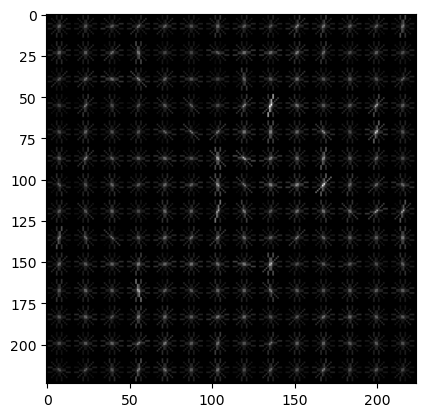

NameError: name 'feature_matrix' is not defined

In [29]:
#Extract feature
# Example usage with the entire training dataset
train_subset = Subset(train_dataset, indices=[0, 1])

hog_feature_matrix, img = hog_features(train_dataset)

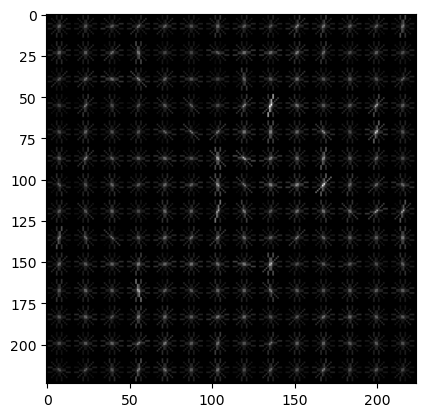

NameError: name 'feature_matrix' is not defined

In [30]:
plt.imshow(img[1], cmap=plt.cm.gray)
plt.show()
print(feature_matrix.shape)

In [31]:
# GLCM
from skimage.feature import greycomatrix, greycoprops

def glcm_features(dataset, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], properties=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']):
    glcm_feature_matrix = []

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        
        # Convert image to grayscale if it's not already
        if image.shape[0] == 3:  # If image is RGB (CxHxW format)
            image = color.rgb2gray(image.permute(1, 2, 0))  # Convert to grayscale and HxWxC format

        # Convert the image to uint8
        image = (image * 255).astype('uint8')
        
        # Calculate GLCM on the grayscale image
        glcm = greycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        glcm_props = [greycoprops(glcm, prop).ravel() for prop in properties]
        
        # Flatten the list of GLCM properties and append to the feature matrix
        glcm_features = np.hstack(glcm_props)
        glcm_feature_matrix.append(glcm_features)
    
    glcm_feature_matrix = np.array(glcm_feature_matrix)
    return glcm_feature_matrix

ImportError: cannot import name 'greycomatrix' from 'skimage.feature' (C:\Users\matia\anaconda3\Lib\site-packages\skimage\feature\__init__.py)

In [ ]:
# extract GLCM features
glcm_feature_matrix = glcm_features(train_dataset)

In [65]:
print(hog_feature_matrix.shape)
print(X.shape)


(7007, 1176)
(7007, 1848)


'\nmodel = resnet18(num_classes=n_classes).cuda()\n\ncriterion = nn.CrossEntropyLoss()\n    \noptimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)'

In [85]:

#X = np.concatenate([hsv_feature_matrix, resnet_feature_matrix, train_lbp_features], axis=1)
X = np.concatenate([hsv_feature_matrix, resnet_feature_matrix, lbp_feature_matrix, hog_feature_matrix], axis=1)


(7007, 512)


In [19]:
# Classifying with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#Cross-validation

logreg = make_pipeline(
    StandardScaler(),
    PCA(n_components=1000),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)


# Logistic Regression hyperparameter grid
logreg_params = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV object
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy')

# Fit the model
logreg_grid.fit(X, labels)

# Best parameters and best score
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Logistic Regression Score:", logreg_grid.best_score_)


C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Best Logistic Regression Parameters: {'logisticregression__C': 0.1, 'logisticregression__solver': 'liblinear'}
Best Logistic Regression Score: 0.7368349080186254


In [100]:
#Actual fitting. Before cross-val
logreg = make_pipeline(
    StandardScaler(),
    #PCA(n_components=1000),
    LogisticRegression(max_iter=1000, C=0.1)
)


# Fit the model
logreg.fit(X, labels)

# Predict on the training set and test set
y_train_pred = logreg.predict(X)


# Calculate accuracy
train_accuracy = accuracy_score(labels, y_train_pred)


print(f'Training Accuracy: {train_accuracy}')


C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.9884401312972741


In [83]:
#Validation

hsv_matrix_val,_,_,_ = hsv_feature(val_dataset)
resnet_matrix_val, labels_val = resnet18_feature(val_loader)
lbp_matrix_val = lbp_features(val_dataset)
hog_matrix_val,_ = hog_features(val_dataset)
#X_val = np.concatenate([hsv_matrix_val, resnet_matrix_val, lbp_matrix_val], axis=1)
print(X_val.shape)


100%|██████████| 8/8 [00:27<00:00,  3.48s/it]


Extracted features shape: (1003, 512)
Labels shape: (1003, 1)


  0%|          | 0/1003 [00:00<?, ?it/s]C:\Users\matia\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 1003/1003 [00:56<00:00, 17.69it/s]


(1003, 2336)


In [86]:
X_val = np.concatenate([hsv_matrix_val, resnet_matrix_val, lbp_matrix_val, hog_matrix_val], axis=1)
print(resnet_matrix_val.shape)

(1003, 512)


In [101]:
y_val_pred = logreg.predict(X_val)


val_accuracy = accuracy_score(labels_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

class_5_mask = (labels_val.reshape(-1) == 5)

# Step 2: Filter the predictions and actual labels
y_val_pred_class_5 = y_val_pred[class_5_mask]
labels_val_class_5 = labels_val[class_5_mask]

# Step 3: Compute accuracy for class 5
val_accuracy_class_5 = accuracy_score(labels_val_class_5, y_val_pred_class_5)

print(f'Validation Accuracy for Class 5: {val_accuracy_class_5}')


Validation Accuracy: 0.7278165503489531
Validation Accuracy for Class 5: 0.8748137108792846


In [22]:
#Random forest cross-validation
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=10),
    RandomForestClassifier(random_state=42, bootstrap=True)
)


rf_params = {
    'randomforestclassifier__n_estimators': [10, 50, 100],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# Create GridSearchCV object
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy')

# Fit the model
rf_grid.fit(X, labels)


C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=10)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20,
                                                               30],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [10, 50, 100]},
             scoring='accuracy')

In [24]:
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Score:", rf_grid.best_score_)

Best Random Forest Parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Best Random Forest Score: 0.699874045541141


In [95]:
#Random forest

from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier pipeline
rf_pipeline = make_pipeline(
    StandardScaler(),
    #PCA(n_components=10),
    RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True, max_samples=3000)
)

# Fit the Random Forest model
rf_pipeline.fit(X, labels)

# Predict on the training set
y_train_pred_rf = rf_pipeline.predict(X)

# Calculate and print the training accuracy
train_accuracy_rf = accuracy_score(labels, y_train_pred_rf)
print(f'Random Forest Training Accuracy: {train_accuracy_rf}')

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Training Accuracy: 0.9658912516055373


In [96]:
y_val_pred_rf = rf_pipeline.predict(X_val)

# Calculate and print the validation accuracy
val_accuracy_rf = accuracy_score(labels_val, y_val_pred_rf)
print(f'Random Forest Validation Accuracy: {val_accuracy_rf}')

Random Forest Validation Accuracy: 0.7238285144566301


In [26]:
#SVM cross-validation
from sklearn.svm import SVC

svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=500),
    SVC(random_state=42)
)

svm_params = {
    'svc__C': [0.001, 0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

# Create GridSearchCV object
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy')

# Fit the model
svm_grid.fit(X, labels)

# Best parameters and best score
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Score:", svm_grid.best_score_)

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best SVM Parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best SVM Score: 0.7723703570203064


In [91]:
#SVM
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_pipeline = make_pipeline(
    StandardScaler(),
    #PCA(n_components=50),
    SVC(random_state=42, C=1, kernel="rbf", class_weight="balanced")
)

# Fit the SVM model
svm_pipeline.fit(X, labels)

# Predict on the training set
y_train_pred_svm = svm_pipeline.predict(X)

# Calculate and print the training accuracy
train_accuracy_svm = accuracy_score(labels, y_train_pred_svm)
print(f'SVM Training Accuracy: {train_accuracy_svm}')

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Training Accuracy: 0.8444412730127016


In [92]:
# Predict on the validation set
y_val_pred_svm = svm_pipeline.predict(X_val)

# Calculate and print the validation accuracy
val_accuracy_svm = accuracy_score(labels_val, y_val_pred_svm)
print(f'SVM Validation Accuracy: {val_accuracy_svm}')


class_5_mask = (labels_val.reshape(-1) == 3)

# Step 2: Filter the predictions and actual labels
y_val_pred_class_5 = y_val_pred_svm[class_5_mask]
labels_val_class_5 = labels_val[class_5_mask]

# Step 3: Compute accuracy for class 5
val_accuracy_class_5 = accuracy_score(labels_val_class_5, y_val_pred_class_5)

print(f'Validation Accuracy for Class 5: {val_accuracy_class_5}')

SVM Validation Accuracy: 0.6999002991026919
Validation Accuracy for Class 5: 0.5833333333333334


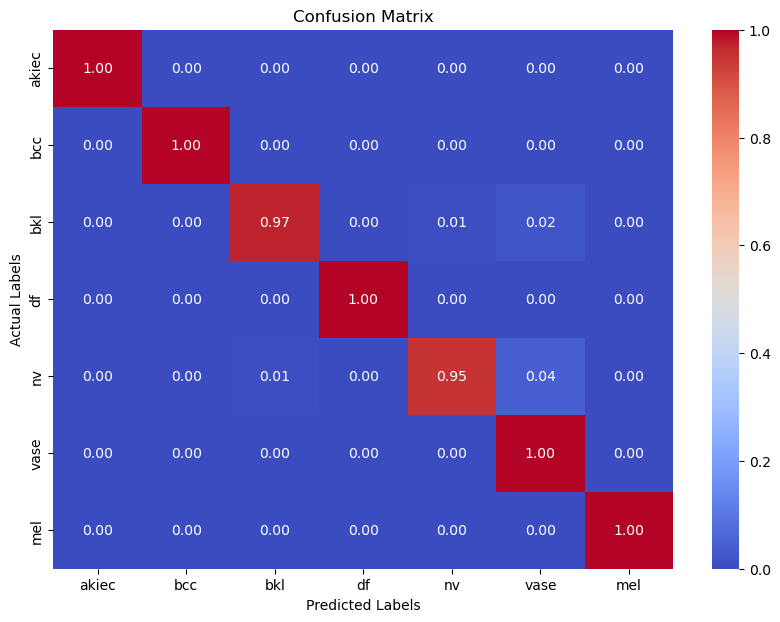

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

#Confusion matrix

cm = confusion_matrix(labels, y_train_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vase', 'mel']
cm_df = pd.DataFrame(cm_normalized, index=class_names, columns=class_names)


# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hsv_scaled = scaler.fit_transform(hsv_feature_matrix)
resnet_scaled = scaler.fit_transform(resnet_feature_matrix)
lbp_scaled = scaler.fit_transform(lbp_feature_matrix)
hog_scaled = scaler.fit_transform(hog_feature_matrix)
print(hsv_scaled)
print(resnet_feature_matrix)
    

[[ 0.08480357  0.40137131 -0.01792474 ... -0.42807938 -0.28623915
  -0.15597902]
 [ 0.30755156  4.10142627  0.12425893 ... -0.42685485 -0.28577685
  -0.15597902]
 [-0.90228346 -0.67160006 -0.3835399  ... -0.13357909 -0.28531456
  -0.15597902]
 ...
 [-0.95141182 -0.66153736 -0.38228349 ... -0.42807938 -0.28623915
  -0.15597902]
 [-0.98334526 -0.67174382 -0.3835399  ... -0.42807938 -0.28623915
  -0.15597902]
 [ 0.32327264 -0.50441548 -0.3835399  ...  0.95839861  0.16935509
  -0.09657151]]
[[0.00277439 0.07897853 0.00528728 ... 0.20195495 0.         0.        ]
 [0.         0.13347487 0.00182985 ... 1.6783407  0.01537561 0.        ]
 [0.51582414 0.26136464 0.         ... 1.4571346  0.16822991 0.00677908]
 ...
 [1.6075689  0.15673506 0.11671676 ... 0.81537265 0.         0.00269551]
 [0.48257285 0.20047596 0.         ... 0.52302694 0.         0.        ]
 [0.23040678 0.6067329  0.15901361 ... 1.6773295  0.00239929 0.        ]]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7007 samples in 0.004s...
[t-SNE] Computed neighbors for 7007 samples in 0.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7007
[t-SNE] Computed conditional probabilities for sample 2000 / 7007
[t-SNE] Computed conditional probabilities for sample 3000 / 7007
[t-SNE] Computed conditional probabilities for sample 4000 / 7007
[t-SNE] Computed conditional probabilities for sample 5000 / 7007
[t-SNE] Computed conditional probabilities for sample 6000 / 7007
[t-SNE] Computed conditional probabilities for sample 7000 / 7007
[t-SNE] Computed conditional probabilities for sample 7007 / 7007
[t-SNE] Mean sigma: 2.555907
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.341049
[t-SNE] KL divergence after 300 iterations: 2.608597
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7007 samples in 0.007s...
[t-SNE] Computed neighbors for 7007 samples in 1.233s...
[t-SNE] Computed conditional

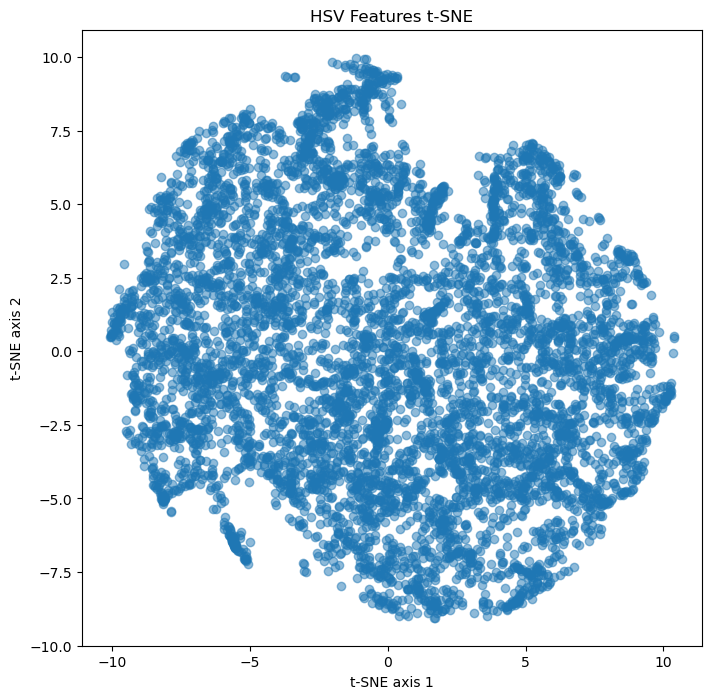

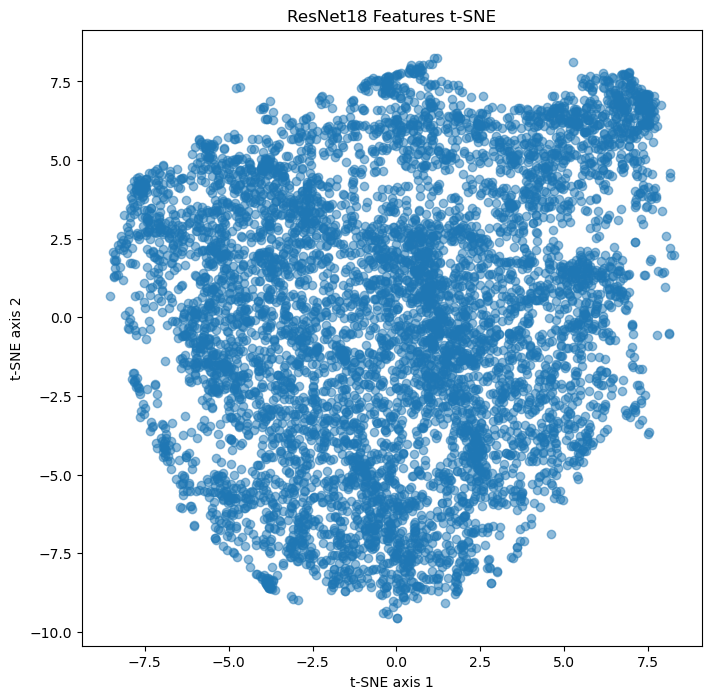

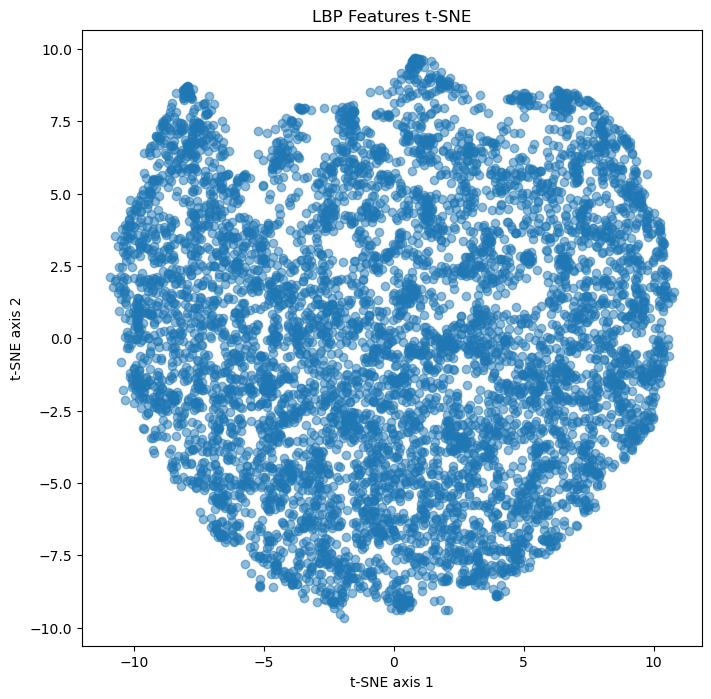

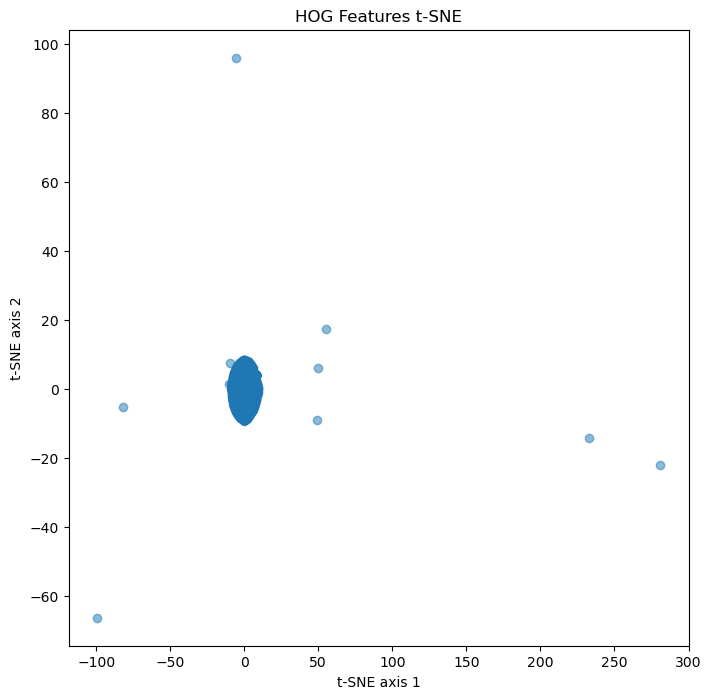

In [57]:
#t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

hsv_tsne_results = tsne.fit_transform(hsv_scaled)
resnet_tsne_results = tsne.fit_transform(resnet_scaled)
lbp_tsne_results = tsne.fit_transform(lbp_scaled)
hog_tsne_results = tsne.fit_transform(hog_scaled)

# Apply t-SNE on combined features 
combined_tsne_results = tsne.fit_transform(X)

def plot_tsne_results(tsne_results, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('t-SNE axis 1')
    plt.ylabel('t-SNE axis 2')
    plt.show()

# Plot results for each feature set
plot_tsne_results(hsv_tsne_results, 'HSV Features t-SNE')
plot_tsne_results(resnet_tsne_results, 'ResNet18 Features t-SNE')
plot_tsne_results(lbp_tsne_results, 'LBP Features t-SNE')
plot_tsne_results(hog_tsne_results, 'HOG Features t-SNE')


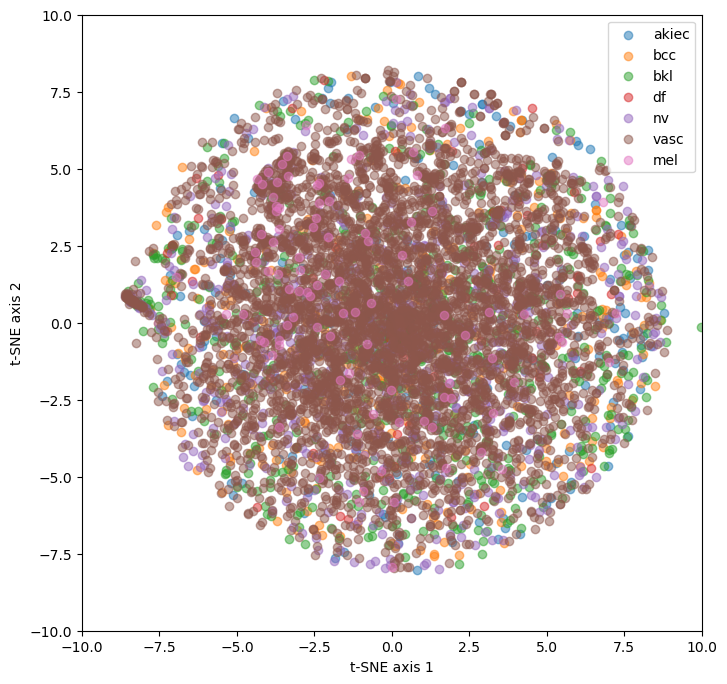

In [56]:
labels = labels.flatten()  # Convert from shape (7007, 1) to (7007,)

# Define class names
class_names = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

plt.figure(figsize=(8, 8))

# Plot each class with a different color and corresponding label name
for i, class_name in enumerate(class_names):
    indices = labels == i
    plt.scatter(combined_tsne_results[indices, 0], combined_tsne_results[indices, 1], label=class_name, alpha=0.5)

#plt.title('t-SNE visualization with Labels')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()  # Add a legend with specified class names
plt.show()

100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


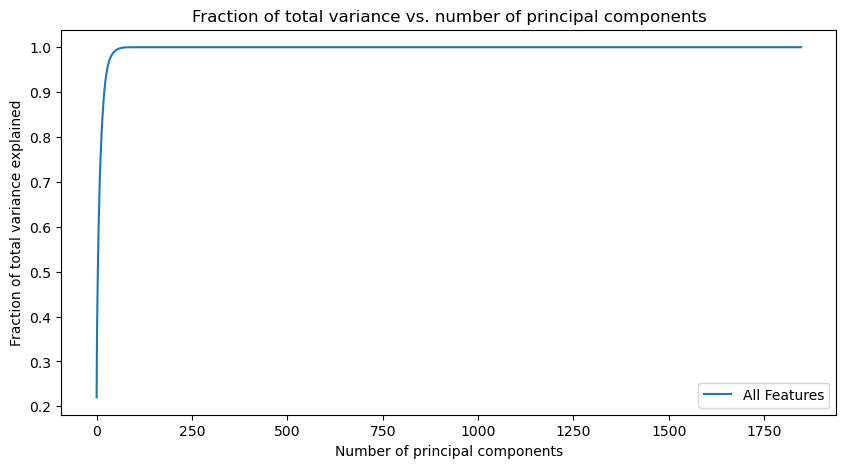

In [63]:
#PCA decompostition
from sklearn.decomposition import PCA


# Assuming hsv_feature_matrix, lbp_feature_matrix, hog_feature_matrix, resnet_feature_matrix, and X are defined
# You will need to standardize your features if they aren't already
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hsv_feature_matrix = scaler.fit_transform(hsv_feature_matrix)
# ...

feature_matrices = {
    #'HSV': hsv_feature_matrix,
    #'LBP': lbp_feature_matrix,
    #'HOG': hog_feature_matrix,
    #'ResNet': resnet_feature_matrix,
    'All Features': X
}

# Function to calculate explained variance for PCA components
def pca_explained_variance(feature_matrix):
    pca = PCA().fit(feature_matrix)
    return np.cumsum(pca.explained_variance_ratio_)

# Plotting the explained variance for each feature set
plt.figure(figsize=(10, 5))
for label, matrix in tqdm(feature_matrices.items()):
    explained_variance = pca_explained_variance(matrix)
    plt.plot(explained_variance, label=label)

plt.xlabel('Number of principal components')
plt.ylabel('Fraction of total variance explained')
plt.title('Fraction of total variance vs. number of principal components')
plt.legend()
plt.show()